<a href="https://colab.research.google.com/github/sidneyarcidiacono/cardiovascular-disease-analysis/blob/main/cardiovascular_disease_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Presence of Cardiovascular Disease

We'll be using [this](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset) dataset and a KNN algorithm provided by SciKit Learn to predict whether or not a patient is likely to have cardiovascular disease.

In [75]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
df = pd.read_csv("https://raw.githubusercontent.com/sidneyarcidiacono/cardiovascular-disease-analysis/main/cardio_train.csv", delimiter=';')

df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [77]:
# Show our basic descriptive statistics about our dataset
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
# What percentage of our patients in this dataset had cardiovascular disease?
df_cardio = df[df["cardio"] == 1]["cardio"]

# Take the number of patients with cardiovascular disease signs and divide by the length 
# of the dataset overall to find percent of patients with cardiovascular disease
len(df_cardio) / len(df) * 100

49.97

It looks like almost 50% of our patients have signs of cardiovascular disease! I wanted to see if this was representative of the population mean. 

Our dataset doesn't tell us where these patients are from, but there is a statistic from the American Heart Association: 

At least 48 percent of U.S. adults have some form of cardiovascular disease, based on the latest statistics provided by the American Heart Association. Feb 19, 2019

In [79]:
# What is the mean age of the patients that we're evaluating? 
# Our dataset gives us age in days, so I'll find the mean and divide by 365 days to approximate the mean age in years
age = df["age"].apply(lambda x: x / 365).mean()
age

53.33935839530379

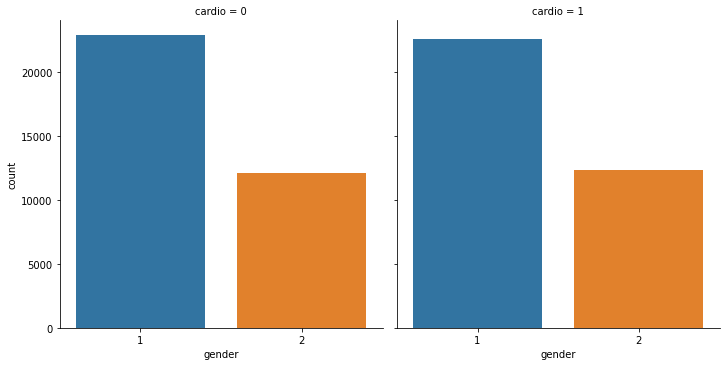

In [80]:
# I want to see what the incidence of cardiovascular disease is for different genders. I'm going to set up a count plot to visualize this.
# 1 = female
# 2 = male
# it looks like there are less males overall, so let's maybe do one more experiment
sns.catplot(x="gender", col="cardio", data=df, kind="count")

In [81]:
# Let's see how many males | females there are

df_male = df[df["gender"] == 2]
df_female = df[df["gender"] == 1]

print(f"Males: {len(df_male)}")
print(f"Females: {len(df_female)}")

Males: 24470
Females: 45530


In [82]:
# Alright, now I want to split them up into groups of 1000, and see if per 1000 patients of each gender
# if there's a difference in the incidence of cardiovascular disease
sample_male = df_male[:1000][df_male["cardio"] == 1]
print(f"# of males with cardiovascular disease out of 1000: {len(sample_male)}")
sample_female = df_female[:1000][df_female["cardio"] == 1]
print(f"# of females with cardiovascular disease out of 1000: {len(sample_female)}")

# of males with cardiovascular disease out of 1000: 495
# of females with cardiovascular disease out of 1000: 502


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


What I can draw from this is that although our original catplot may have been a bit confusing, there isn't a significant difference in patients with cardiovascular disease between males and females in our sample. 

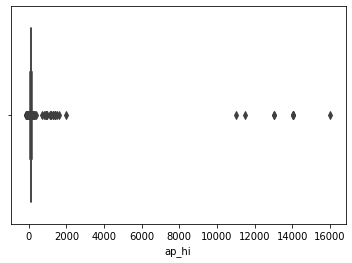

In [83]:
# I wanted to see if there was a relationship between a patient's age and their blood pressure, but in the process of plotting that
# I found out that there are some really strange values in our blood pressure (ap_hi and ap_lo) columns. 
# So, instead, I'm going to use a boxplot to see if there are some potential outliers, and remove them if there are. 

sns.boxplot(x="ap_hi", data=df)

# So, yeah this looks pretty messed up. Let's go through and clip out some outliers. We shouldn't really have any values in the 10's of thousands for blood pressure.

In [89]:
# I'm going to use the IQR method to clip outliers from both the ap_lo and ap_hi columns 

# First, I'm going to sort both columns and find the first and third quartiles of both systolic and diastolic bp

q1_hi, q3_hi = np.percentile(sorted(df["ap_hi"]), [25, 75])
q1_lo, q3_lo = np.percentile(sorted(df["ap_lo"]), [25, 75])

# Then, we subtract the first quartile from the third to find our interquartile range
iqr_hi = q3_hi - q1_hi
iqr_lo = q3_lo - q3_lo

# Now, I want to find lower and upper bounds for both columns

upper_bound_hi = q3_hi +(1.5 * iqr_hi) 
lower_bound_hi = q1_hi -(1.5 * iqr_hi)

upper_bound_lo = q3_lo +(1.5 * iqr_lo) 
lower_bound_lo = q1_lo - (1.5 * iqr_lo) 

print(f"Upper bound systolic bp: {upper_bound_hi}")
print(f"Lower bound systolic bp: {lower_bound_hi}")

print(f"Upper bound diastolic bp: {upper_bound_lo}")
print(f"Lower bound diastolic bp: {lower_bound_lo}")

# Now that we know what our lower and upper bounds are, we're going to clip out the outliers to avoid the strange behavior we were getting earlier.
clean_df = df[(df["ap_hi"] > lower_bound_hi) & (df["ap_hi"] < upper_bound_hi) & (df["ap_lo"] > lower_bound_lo) & (df["ap_lo"] < upper_bound_lo)]

clean_age = clean_df["age"].apply(lambda x: x / 365)

Upper bound systolic bp: 170.0
Lower bound systolic bp: 90.0
Upper bound diastolic bp: 90.0
Lower bound diastolic bp: 80.0


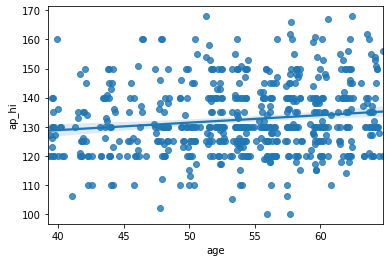

In [90]:
# Now that we've done aaaaaallllll of that, we can try to plot our age against our systolic bp, and see if there's any relationship. 

sns.regplot(x=clean_age, y=clean_df["ap_hi"], data=clean_df)

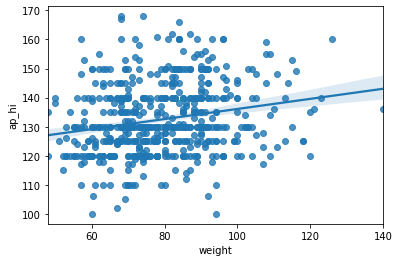

In [91]:
# Alright, so after all of that we can safely say that these two data points really don't have a relationship. What about weight and blood pressure? 
sns.regplot(x=clean_df["weight"], y=clean_df["ap_hi"], data=clean_df)

In [92]:
# Hmm, less of a relationship than I thought! That's okay, let's see if we can make decent classifications with the rest of the features considered. 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# First, I want to get our X and y, and do our train/test split
X = clean_df.drop("cardio", axis=1)
y = clean_df["cardio"]

# Use sklearn's train_test_split method
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [93]:
for k in range(10, 30):
  # get an object representing our model or algorithm
  knn = KNeighborsClassifier(n_neighbors=k)

  # "fit" or train model on training data
  knn.fit(X_train, y_train)

  # Check out training accuracy
  print(f"K = {k}")
  print(f"Training accuracy: {knn.score(X_train, y_train)}")
  print(f"Test accuracy: {knn.score(X_test, y_test)}")

K = 10
Training accuracy: 0.6418918918918919
Test accuracy: 0.5234899328859061
K = 11
Training accuracy: 0.6486486486486487
Test accuracy: 0.5436241610738255
K = 12
Training accuracy: 0.6328828828828829
Test accuracy: 0.5302013422818792
K = 13
Training accuracy: 0.6328828828828829
Test accuracy: 0.5369127516778524
K = 14
Training accuracy: 0.6148648648648649
Test accuracy: 0.5436241610738255
K = 15
Training accuracy: 0.6306306306306306
Test accuracy: 0.5570469798657718
K = 16
Training accuracy: 0.6238738738738738
Test accuracy: 0.5637583892617449
K = 17
Training accuracy: 0.6103603603603603
Test accuracy: 0.5637583892617449
K = 18
Training accuracy: 0.6261261261261262
Test accuracy: 0.5302013422818792
K = 19
Training accuracy: 0.6193693693693694
Test accuracy: 0.5637583892617449
K = 20
Training accuracy: 0.6193693693693694
Test accuracy: 0.5503355704697986
K = 21
Training accuracy: 0.6306306306306306
Test accuracy: 0.5570469798657718
K = 22
Training accuracy: 0.6261261261261262
Test ac

In [94]:
# I want to do one more experiment with the dataset that wasn't clipped of outliers, just in case
# First, I want to get our X and y, and do our train/test split
X = df.drop("cardio", axis=1)
y = df["cardio"]

# Use sklearn's train_test_split method
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [95]:
for k in range(10, 30):
  # get an object representing our model or algorithm
  knn = KNeighborsClassifier(n_neighbors=k)

  # "fit" or train model on training data
  knn.fit(X_train, y_train)

  # Check out training accuracy
  print(f"K = {k}")
  print(f"Training accuracy: {knn.score(X_train, y_train)}")
  print(f"Test accuracy: {knn.score(X_test, y_test)}")

K = 10
Training accuracy: 0.6575619047619048
Test accuracy: 0.5657142857142857
K = 11
Training accuracy: 0.6600952380952381
Test accuracy: 0.5727428571428571
K = 12
Training accuracy: 0.6506095238095239
Test accuracy: 0.5718285714285715
K = 13
Training accuracy: 0.6510857142857143
Test accuracy: 0.5777142857142857
K = 14
Training accuracy: 0.6444
Test accuracy: 0.5750285714285714
K = 15
Training accuracy: 0.6463047619047619
Test accuracy: 0.5777714285714286
K = 16
Training accuracy: 0.6404380952380953
Test accuracy: 0.5753142857142857
K = 17
Training accuracy: 0.6409142857142858
Test accuracy: 0.5792
K = 18
Training accuracy: 0.6357714285714285
Test accuracy: 0.5784
K = 19
Training accuracy: 0.6346095238095238
Test accuracy: 0.5781142857142857
K = 20
Training accuracy: 0.6317142857142857
Test accuracy: 0.5784571428571429
K = 21
Training accuracy: 0.6320571428571429
Test accuracy: 0.5790285714285714
K = 22
Training accuracy: 0.628095238095238
Test accuracy: 0.5777142857142857
K = 23
Tra

Conclusions: 

- There were some tricky datapoints in this dataset, that I would love to explore further. 

- Our KNN model didn't really seem to do well, even with the cleaned data. I wonder if this is due to features that don't have much to do with each other, or data that just isn't well normalized. 

- Because of this, I'm curious if a different type of model would do better, or if it would really just take a better understanding of normalizing data/how KNN works to find an optimal solution! 

- I plan on revisiting this dataset later to perform some more experiments, and see if I can get more practical results! 